## 1) Import Libraries and Load Data

In [2]:

# Last modified: October 26, 2018

# This model runs Rich Kichnet's random forest model using randomly-
# generated train and test splits and an expanded feature set.

In [3]:
# Load Python libraries

import pandas as pd
import numpy as np
import matplotlib as zzz
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm

from sklearn.utils import resample

import itertools

# sns.set_style("whitegrid")
# sns.set_context("poster")

Using TensorFlow backend.


In [4]:
# Pull data from .csv file

df = pd.read_csv('Full_Data_Set.csv', encoding = "ISO-8859-1")
df_original = df.copy()

In [5]:
df.head()

,Group,groupsubmissionid,PolicyNumber,Status,RSE_Name,RSS_Name,Underwriter_Name,BrokerName,TopBrokerInd,StateName,...,Wells_Stephen_Bronder,Willis_Andy_Cookingham,Willis_David_Johnson,Willis_Richard_Bradford,Include,X,X.1,X.2,X.3,Train
0,e,0f0c07cf-cba4-407f-a025-5489b1e07a99,NaN,Quoted,Chris Tate,Lauren Bishop,Lauren Bishop,Charon Planning,0,NJ,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1
1,Fayette Resources,2f5e1bf9-0a04-4034-b43c-59d40eb53089,NaN,Dead,Stephen Bronder,Mary Stasik,Ellen Calitri,Willis,1,PA,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
2,Fortegra Financial,0b8ab22e-c7a0-478c-80cc-61eaf0a339a3,NaN,Dead,Chris Farmen,Mary Hewitt,Tyler Adams,Greene Hazel,0,FL,...,0,0,0,0,3,NaN,NaN,NaN,NaN,1
3,"Industrial Valve Sales & Service, Inc.",59291dde-bca0-439e-afc5-25b686131a45,NaN,Dead,Richard Bradford,Dawn Cornelius,Matthew Jadovich,HUB International,0,AL,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
4,"Industrial Valve Sales & Service, Inc.",62bc3d72-f2af-4cc9-8eb5-25c26c7485bd,NaN,Quoted,Richard Bradford,Dawn Cornelius,Eric Elam,HUB International,0,AL,...,0,0,0,0,3,NaN,NaN,NaN,NaN,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15211 entries, 0 to 15210
Columns: 172 entries, Group to Train
dtypes: float64(32), int64(129), object(11)
memory usage: 20.0+ MB


In [7]:
#katovc
df_nan=df[df.isnull().any(axis=1)]
df_nan.head()


,Group,groupsubmissionid,PolicyNumber,Status,RSE_Name,RSS_Name,Underwriter_Name,BrokerName,TopBrokerInd,StateName,...,Wells_Stephen_Bronder,Willis_Andy_Cookingham,Willis_David_Johnson,Willis_Richard_Bradford,Include,X,X.1,X.2,X.3,Train
0,e,0f0c07cf-cba4-407f-a025-5489b1e07a99,NaN,Quoted,Chris Tate,Lauren Bishop,Lauren Bishop,Charon Planning,0,NJ,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1
1,Fayette Resources,2f5e1bf9-0a04-4034-b43c-59d40eb53089,NaN,Dead,Stephen Bronder,Mary Stasik,Ellen Calitri,Willis,1,PA,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
2,Fortegra Financial,0b8ab22e-c7a0-478c-80cc-61eaf0a339a3,NaN,Dead,Chris Farmen,Mary Hewitt,Tyler Adams,Greene Hazel,0,FL,...,0,0,0,0,3,NaN,NaN,NaN,NaN,1
3,"Industrial Valve Sales & Service, Inc.",59291dde-bca0-439e-afc5-25b686131a45,NaN,Dead,Richard Bradford,Dawn Cornelius,Matthew Jadovich,HUB International,0,AL,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
4,"Industrial Valve Sales & Service, Inc.",62bc3d72-f2af-4cc9-8eb5-25c26c7485bd,NaN,Quoted,Richard Bradford,Dawn Cornelius,Eric Elam,HUB International,0,AL,...,0,0,0,0,3,NaN,NaN,NaN,NaN,0


In [8]:
# The portion of cases that resulted in a Sale

print("Percentage of Cases Sold: %.4f" % (100 * df.Sold.sum() / df.shape[0]) + '%')

Percentage of Cases Sold: 9.4405%


<h2> katovc comment </h2>
<p> Is it ok to replace all nan to 0?. Need to verify that major vriables are not affected </p>

In [9]:
# Replace all NaN with 0

df.fillna(0, inplace=True)

In [10]:
# Group is not descriptive -> drop
# groupsubmissionid is not descriptive -> drop
# PolicyNumber is not descriptive -> drop
# Status gives away final disposition of case -> drop
# Keep RSE_Name -> convert to ratio
# Keep RSS_Name -> convert to ratio
# Underwriter_Name -> convert to ratio
# BrokerName -> convert to ratio
# TopBroker is redundant -> discard
# StateName -> convert to region
# What is SIC Code?
# EffectiveMonth -> convert to 11 columns one-hot
# EffectiveYear -> no trend with QTI, drop
# GroupNameMaxLives redundant -> drop
# GroupIdMaxLives redundant -> drop
# Segment -> 0, 1, 2
# CloseRatioNumerator redundant -> drop

In [11]:
df.drop(['Group', 'groupsubmissionid', 'PolicyNumber',
         'Status', 'TopBrokerInd', 'SIC_Code', 'EffectiveYear',
         'GroupNameMaxLives', 'GroupIdMaxLives',
         'CloseRatioNumerator'], axis=1, inplace=True)

In [12]:
list(df.columns)

['RSE_Name',
 'RSS_Name',
 'Underwriter_Name',
 'BrokerName',
 'StateName',
 'EffectiveMonth',
 'MaxLives',
 'Segment',
 'Life',
 'LTD',
 'STD',
 'QuotedAnnualPremium',
 'InforceAnnualPremium',
 'FormulaAnnualPremium',
 'ManualAnnualPremium',
 'NeededAnnualPremium',
 'LifeQuotedAnnualPremium',
 'LTDQuotedAnnualPremium',
 'STDQuotedAnnualPremium',
 'LifeInforceAnnualPremium',
 'LTDInforceAnnualPremium',
 'STDInforceAnnualPremium',
 'LifeFormulaAnnualPremium',
 'LTDFormulaAnnualPremium',
 'STDFormulaAnnualPremium',
 'LifeManualAnnualPremium',
 'LTDManualAnnualPremium',
 'STDManualAnnualPremium',
 'LifeNeededAnnualPremium',
 'LTDNeededAnnualPremium',
 'STDNeededAnnualPremium',
 'QTI',
 'QTI_Range_7',
 'QTI_Range_5',
 'QuotedPremium_CR',
 'SoldPremium_CR',
 'Matthew_Jadovich',
 'Eric_Elam',
 'Michael_Reed',
 'Chris_Brown',
 'Peter_Klepadlo',
 'Tangie_Jewell',
 'Peter_Ouellette',
 'Zachary_Papotto',
 'David_Spak',
 'Rich_Kichnet',
 'Amy_Kniffen',
 'Ben_Shehu',
 'Dan_Dalton',
 'Brad_Johnson'

## 2) Exploratory Data Analysis & Feature Selection

Text(0.5,1,'Class Distributions: Unsold (0) vs. Sold (1)')

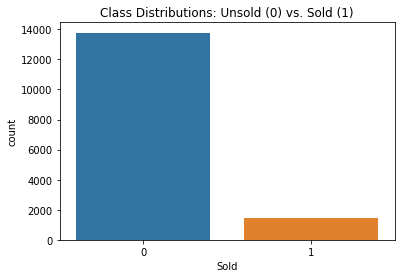

In [13]:
sns.countplot('Sold', data=df);
plt.title('Class Distributions: Unsold (0) vs. Sold (1)')

Text(0,0.5,'Proportion Sold')

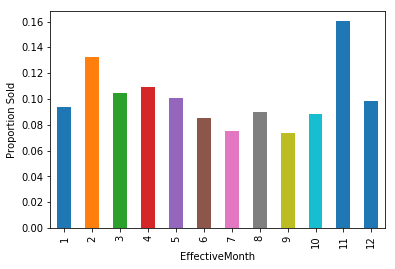

In [14]:
# Proportion sold by month of the year

pd.Series(df.Sold.groupby(df.EffectiveMonth).sum() / df.Sold.groupby(df.EffectiveMonth).count()).plot(kind="bar")
plt.ylabel('Proportion Sold')

Text(0,0.5,'Case count by month')

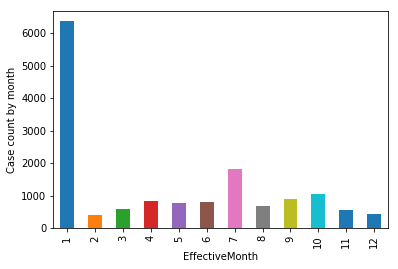

In [15]:
# katovc

pd.Series(df.groupby(df.EffectiveMonth).size()).plot(kind="bar")
plt.ylabel('Case count by month')

In [16]:
# Split EffectiveMonth into separate columns corresponding to each month

df = pd.concat([df, pd.get_dummies(df.EffectiveMonth, drop_first=True, prefix='Month')], axis=1)

In [17]:
df.drop('EffectiveMonth', axis=1, inplace=True)

In [18]:
# Separate states into region of the US

west = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO']
southwest = ['AZ', 'NM', 'OK', 'TX']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
northeast = ['ME', 'NH', 'VT', 'MA', 'NY', 'RI', 'CT', 'NJ', 'PA']
southeast = ['WV', 'DE', 'MD', 'VA', 'DC', 'KY', 'TN', 'NC', 'AR', 'LA', 'MS', 'AL', 'GA', 'SC', 'FL']

df['west'] = np.where(df['StateName'].isin(west), 1, 0)
df['southwest'] = np.where(df['StateName'].isin(southwest), 1, 0)
df['midwest'] = np.where(df['StateName'].isin(midwest), 1, 0)
df['northeast'] = np.where(df['StateName'].isin(northeast), 1, 0)
df['southeast'] = np.where(df['StateName'].isin(southeast), 1, 0)

In [19]:
# Convert Segment to 0, 1, and 2

df = pd.concat([df, pd.get_dummies(df.Segment, drop_first=True, prefix='Segment')], axis=1)

In [20]:
df.drop('Segment', axis=1, inplace=True)

In [21]:
# Function that creates a dictionary of proportion of cases sold

def create_dict(series):
    dict_prop = pd.Series(train.groupby(series.name)['Sold'].sum() /
                          train.groupby(series.name)['Sold'].count()).to_dict()
    return dict_prop

In [22]:
# Function that generates ratio of sold cases over total cases for any categorical feature

def proportion(series):
    dict_prop = create_dict(series)
    
    proportions = []
    for ii in series:
        if pd.isnull(ii):
            proportions.append(0)
            # print('Null')
        elif ii not in dict_prop:
            proportions.append(0)
            # print(ii)
        else:
            proportions.append(dict_prop[ii])
            # print('Found')
    return(pd.Series(proportions))

In [23]:
# Generate train set and test set

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('Sold', axis=1), df.Sold, shuffle=True, random_state=1)

In [24]:
#katovc: is dropping index nessessary? won't be able to trace cases to the original dataset
Xtrain = Xtrain.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
ytrain = ytrain.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

In [25]:
df.head()

,RSE_Name,RSS_Name,Underwriter_Name,BrokerName,StateName,MaxLives,Life,LTD,STD,QuotedAnnualPremium,...,Month_11,Month_12,west,southwest,midwest,northeast,southeast,Segment_LM,Segment_MM,Segment_SM
0,Chris Tate,Lauren Bishop,Lauren Bishop,Charon Planning,NJ,40.0,1,1,1,76169.8900,...,0,0,0,0,0,1,0,0,0,1
1,Stephen Bronder,Mary Stasik,Ellen Calitri,Willis,PA,664.0,1,1,1,114226.8463,...,0,0,0,0,0,1,0,0,1,0
2,Chris Farmen,Mary Hewitt,Tyler Adams,Greene Hazel,FL,453.0,1,1,1,257961.2820,...,0,0,0,0,0,0,1,0,0,1
3,Richard Bradford,Dawn Cornelius,Matthew Jadovich,HUB International,AL,298.0,1,1,1,191220.7870,...,0,0,0,0,0,0,1,0,0,1
4,Richard Bradford,Dawn Cornelius,Eric Elam,HUB International,AL,252.0,1,1,1,225829.5970,...,0,0,0,0,0,0,1,0,0,1


In [26]:
train = pd.concat([Xtrain, ytrain], axis=1)
test = pd.concat([Xtest, ytest], axis=1)

In [27]:
### Bin QTI in order to minimize right-skew

train['QTI_binned'], bins = pd.qcut(train.QTI, q=4
                                    , labels=False, retbins=True)
test['QTI_binned'] = pd.cut(test.QTI, bins, labels=False)
print(bins)

[1.990000e-02 9.604750e-01 1.000000e+00 1.103325e+00 8.264460e+01]


Text(0,0.5,'Proportion Sold vs. QTI')

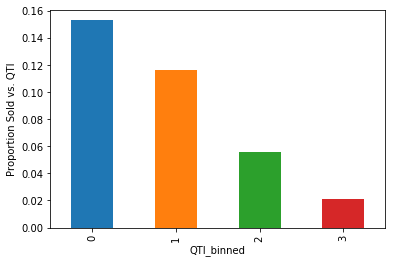

In [28]:
pd.Series(train.Sold.groupby(train.QTI_binned).sum() / train.Sold.groupby(train.QTI_binned).count()).plot(kind="bar")
plt.ylabel('Proportion Sold vs. QTI')

C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


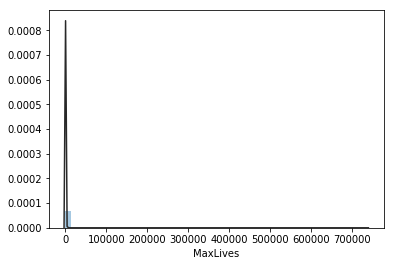

In [29]:
#katovc
#sns.distplot(train.MaxLives)

from scipy import stats
sns.distplot(train.MaxLives, kde=False, fit=stats.expon) #lognorm is the same

In [30]:
# Bin MaxLives in order to minimize right-skew

train['MaxLives_binned'], bins = pd.qcut(train.MaxLives, q=3, labels=False, retbins=True)
test['MaxLives_binned'] = pd.cut(test.MaxLives, bins, labels=False)
print(bins)

[0.00000000e+00 1.54000000e+02 4.07666667e+02 7.37369000e+05]


Text(0,0.5,'Proportion Sold')

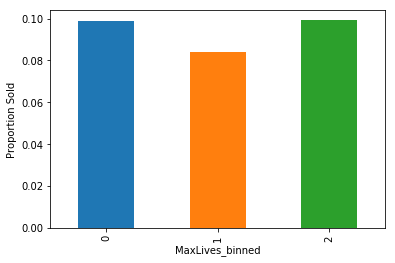

In [31]:
pd.Series(train.groupby('MaxLives_binned')['Sold'].sum() / train.groupby('MaxLives_binned')['Sold'].count()).plot(kind="bar")
plt.ylabel('Proportion Sold')

Text(0,0.5,'Max Lives')

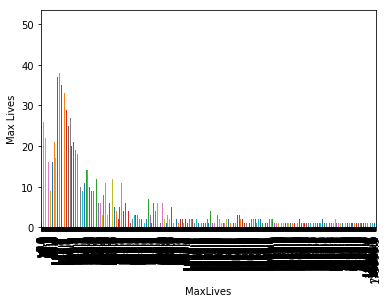

In [32]:
# katovc

pd.Series(train.groupby(train.MaxLives).size()).plot(kind="bar")
plt.ylabel('Max Lives')

In [33]:
# Bin QuotedAnnualPremium in order to minimize right skew

train['QuotedAnnualPremium_binned'], bins = pd.qcut(train.QuotedAnnualPremium, q=5, labels=False, retbins=True)
test['QuotedAnnualPremium_binned'] = pd.cut(test.QuotedAnnualPremium, bins, labels=False)

train['QuotedAnnualPremium_log']=np.log(train.QuotedAnnualPremium)
test['QuotedAnnualPremium_log']=np.log(test.QuotedAnnualPremium)

print(bins)

[1.10000000e+02 2.40361120e+04 6.83366354e+04 1.33431082e+05
 3.06331067e+05 3.51426285e+07]


Text(0,0.5,'Proportion Sold')

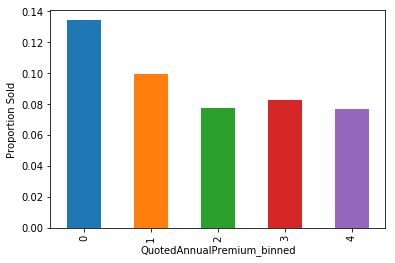

In [34]:
pd.Series(train.groupby('QuotedAnnualPremium_binned')['Sold'].sum() / train.groupby('QuotedAnnualPremium_binned')['Sold'].count()).plot(kind="bar")
plt.ylabel('Proportion Sold')

In [35]:
# Keep RSE_Name -> convert to ratio
# Keep RSS_Name -> convert to ratio
# Underwriter_Name -> convert to ratio
# BrokerName -> convert to ratio

In [36]:
# Generate sold ratio for categorical variable RSE_Name

test['RSE_Name_ratio'] = proportion(test.RSE_Name)
train['RSE_Name_ratio'] = proportion(train.RSE_Name)

In [37]:
# Generate sold ratio for categorical variable RSS_Name

test['RSS_Name_ratio'] = proportion(test.RSS_Name)
train['RSS_Name_ratio'] = proportion(train.RSS_Name)

In [38]:
# Generate sold ratio for categorical variable BrokerName_ratio

test['BrokerName_ratio'] = proportion(test.BrokerName)
train['BrokerName_ratio'] = proportion(train.BrokerName)

#test['BrokerName_ratio'] = np.cbrt(proportion(test.BrokerName))
#train['BrokerName_ratio'] = np.cbrt(proportion(train.BrokerName))

In [39]:
len(train.BrokerName_ratio)

11408

In [40]:
sum(train.BrokerName_ratio == 0)

4289

In [41]:
# Generate sold ratio for categorical variable Underwriter_Name

test['Underwriter_Name_ratio'] = proportion(test.Underwriter_Name)
train['Underwriter_Name_ratio'] = proportion(train.Underwriter_Name)

In [42]:
train.head()

,RSE_Name,RSS_Name,Underwriter_Name,BrokerName,StateName,MaxLives,Life,LTD,STD,QuotedAnnualPremium,...,Segment_SM,Sold,QTI_binned,MaxLives_binned,QuotedAnnualPremium_binned,QuotedAnnualPremium_log,RSE_Name_ratio,RSS_Name_ratio,BrokerName_ratio,Underwriter_Name_ratio
0,Mark Crisler,Christina Herrin,Peter Klepadlo,HUB International,WA,200.0,1,0,0,6.888660e+03,...,1,0,2,1,0,8.837632,0.136318,0.095290,0.099099,0.170732
1,Mark Crisler,Morgan Franovich,0,Alligence,MT,196.0,0,1,0,3.410400e+04,...,1,0,1,1,1,10.437170,0.136318,0.151448,0.000000,0.025114
2,Paul Monica,Dawn Cornelius,Ben Shehu,Holmes Murphy,TX,2361.0,1,1,1,1.969744e+06,...,0,0,3,2,4,14.493414,0.087500,0.080055,0.022727,0.127273
3,Julie Bosse,Christine Bozza,Keith Daigle,Gottlieb Associates,MA,35.0,0,1,1,1.648664e+04,...,1,1,1,0,0,9.710305,0.080645,0.084227,0.111111,0.090452
4,Johnathan Gingras,Sarah Finch,Peter Ouellette,Charon,NY,314.0,0,0,1,2.837304e+04,...,1,1,0,1,1,10.253195,0.066667,1.000000,0.666667,0.138702


In [43]:
test.head()

,RSE_Name,RSS_Name,Underwriter_Name,BrokerName,StateName,MaxLives,Life,LTD,STD,QuotedAnnualPremium,...,Segment_SM,Sold,QTI_binned,MaxLives_binned,QuotedAnnualPremium_binned,QuotedAnnualPremium_log,RSE_Name_ratio,RSS_Name_ratio,BrokerName_ratio,Underwriter_Name_ratio
0,Steve Mezei,Lauren Bishop,Dan Dalton,USI Insurance Services,NC,2241.0,1,1,1,809758.6400,...,0,0,3.0,2.0,4,13.604492,0.092593,0.051325,0.076923,0.192308
1,Chris Koettker,Christina Herrin,David Spak,Holmes Murphy & Associates,TX,941.0,1,1,1,683716.0560,...,0,0,2.0,2.0,4,13.435298,0.137931,0.095290,0.000000,0.192771
2,Chris Koettker,Beth Dykeman,Beth Dykeman,Ahart Benefit Insurance,CA,40.0,1,0,0,2880.0000,...,1,0,0.0,0.0,0,7.965546,0.137931,0.195402,0.000000,0.186916
3,Randy Alsworth,Ross Meister,Matthew Doucette,HM Benefits,MO,106.0,1,0,0,27307.2000,...,1,0,1.0,0.0,1,10.214906,0.041667,0.110345,0.000000,0.137427
4,Stephen Bronder,Mary Stasik,Kyle Marinko,HDH Group,PA,686.0,1,1,0,270397.7316,...,0,0,3.0,2.0,3,12.507649,0.112195,0.093812,1.000000,0.041176


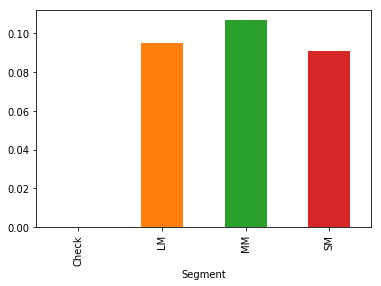

In [44]:
pd.Series(df_original.Sold.groupby(df_original.Segment).sum() / df_original.Sold.groupby(df_original.Segment).count()).plot(kind='bar')

In [45]:
features=[
 'RSE_Name_ratio',
 'BrokerName_ratio',
 'Underwriter_Name_ratio',
 'Life',
 'LTD',
 'STD',
 #'QuotedAnnualPremium_log',
 'QuotedAnnualPremium_binned',
 'QTI',
 'Sold'
]

# features=[
#  'RSE_Name_ratio',
#  'RSS_Name_ratio',
#  'Underwriter_Name_ratio',
#  'BrokerName_ratio',
#  'MaxLives_binned',
#  'Life',
#  'LTD',
#  'STD',
#  'QuotedAnnualPremium_binned',
#   'west',
#  'southwest',
#  'midwest',
#  'northeast',
#  'southeast',
#  'Segment_LM',
#  'Segment_MM',
#  'Segment_SM',
#  'QTI',
#  'Sold'
# ]
csv_train = train[features]
csv_test = test[features]

In [46]:
csv_test = test[features]

In [47]:
csv_train.isnull().any()

RSE_Name_ratio                False
BrokerName_ratio              False
Underwriter_Name_ratio        False
Life                          False
LTD                           False
STD                           False
QuotedAnnualPremium_binned    False
QTI                           False
Sold                          False
dtype: bool

In [48]:
csv_test.isnull().any()

RSE_Name_ratio                False
BrokerName_ratio              False
Underwriter_Name_ratio        False
Life                          False
LTD                           False
STD                           False
QuotedAnnualPremium_binned    False
QTI                           False
Sold                          False
dtype: bool

# Clean up MaxLives that were assigned NaN during binning

csv_test[csv_test.MaxLives_binned.isnull()]

test[test.MaxLives_binned.isnull()].MaxLives

csv_test.loc[610, 'MaxLives_binned'] = 0
csv_test.loc[2143, 'MaxLives_binned'] = 0

csv_test[csv_test.MaxLives_binned.isnull()]

csv_test.MaxLives_binned.value_counts()

#### csv_test[csv_test.QTI_binned.isnull()]

#### test[test.QTI_binned.isnull()].QTI

#### csv_test.loc[2409, 'QTI_binned'] = 0

#### csv_test[csv_test.QTI_binned.isnull()]

#### csv_test.QTI_binned.value_counts()

In [49]:
# Cap QTI at 2.00

csv_train.iloc[csv_train.loc[csv_train.QTI > 2].index,-2] = 2

C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
csv_test.iloc[csv_test.loc[csv_test.QTI > 2].index,-2] = 2

In [51]:
# Then normalize between 0 and 1

#katovc: why dividing by 2? need to normalize

csv_train.QTI = csv_train.QTI / 2

C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [52]:
csv_test.QTI = csv_test.QTI / 2

csv_train.QuotedAnnualPremium_binned/4

In [53]:
# Also normalize QuotedAnnualPremium

csv_train.QuotedAnnualPremium_binned = csv_train.QuotedAnnualPremium_binned / 4
csv_test.QuotedAnnualPremium_binned = csv_test.QuotedAnnualPremium_binned / 4

In [54]:
csv_test.QTI.min()

0.00445

In [55]:
csv_train.QTI.min()

0.00995

# Also normalize MaxLives

csv_train.MaxLives_binned = csv_train.MaxLives_binned / 4
csv_test.MaxLives_binned = csv_test.MaxLives_binned / 4

## 3) Machine Learning

In [56]:
# Define a function that runs the machine learning algorithm:

def run_clf(classifier, classifier_name, Xtrain, ytrain, Xtest, ytest):

    clf = classifier
    clf.fit(Xtrain.values, ytrain.values)
    ypred = clf.predict(Xtest.values)
    accuracy = accuracy_score(ytest.values,ypred)
    precision, recall, f1 = metrics(ytest.values, ypred)


    kf = KFold(n_splits=5)
    scores = cross_val_score(classifier, Xtrain.values, ytrain.values, cv=kf)
    kf_score = np.mean(scores)
    
    print("Baseline Accuracy: %.4f" % accuracy_score(ytest.values, ytest.values * [0]))
    print("=======================================")
    print(classifier_name + " Training Accuracy: %.4f" % kf_score)
    print(classifier_name + " Test Accuracy: %.4f" % accuracy_score(ytest.values, ypred))
    print(classifier_name + " Precision: %.4f" % precision)
    print(classifier_name + " Recall: %.4f" % recall)
    print(classifier_name + " F1: %.4f" % f1)
    
    print_cm(ytest, ypred)
    
    plot_ROC(classifier, classifier_name, Xtest, ytest)
    
    return ypred
    
    #plot_probs(classifier, classifier_name, Xtest)
    

In [57]:
# Define a function that draws the confusion matrix

def print_cm(ytest,ypred):
    
    plt.figure()
    
    cm = confusion_matrix(ytest,ypred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [58]:
# Define a function that plots the ROC curve

def plot_ROC(clf, clf_name, Xtest, ytest):
    
    probs = clf.predict_proba(Xtest.values)
    probs = probs[:,1]
    
    # calculate AUC
    auc = roc_auc_score(ytest.values, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    # plot no skill
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', label='ROC curve (area = %0.2f)' % auc)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.title(clf_name)
    plt.xlabel("False Positive Rate");
    plt.ylabel("True Positive Rate");
    plt.legend(loc="lower right")
    
    plt.figure()
    
    plt.hist(probs, bins=100);
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Probabilities via ' + clf_name + ' Model')

In [59]:
# Function to generate statistical metrics for imbalanced data sets

def metrics(pred, ytest):
    tn, fp, fn, tp = confusion_matrix(ytest, pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 0.5*(precision + recall)
    return(precision, recall, f1)

In [60]:
# Function to print confusion matrix

def print_cm(ytest,ypred):
    
    cm = confusion_matrix(ytest,ypred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
# Function to plot probability distribution

def plot_probs(classifier, classifier_name, Xtest):

    probs = classifier.predict_proba(Xtest)
    probs = probs[:,1]

    plt.figure()
    
    plt.hist(probs, bins=100);
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Probabilities via ' + classifier_name + ' Model')

In [62]:
# Function to plot feature weights

def plot_features(weights, indices):
    
    plot_coefficients = pd.DataFrame(abs(weights),
                                   index = indices).sort_values(by=0, ascending=False)

    fig, ax = plt.subplots(figsize=(10, 5))
    plot_coefficients.plot(kind='bar', ax=ax)
    ax.legend_.remove()

In [63]:
  csv_train.RSE_Name_ratio.min()

0.0

In [64]:
#Kate's balancing train set
from imblearn.under_sampling import RandomUnderSampler

nr = RandomUnderSampler(random_state=50)
X_train_nr, y_train_nr = nr.fit_sample(csv_train.iloc[:,:-1], csv_train.iloc[:,-1])
X_train_nr=pd.DataFrame(X_train_nr, columns=csv_train.iloc[:,:-1].columns)
y_train_nr=pd.Series(y_train_nr)


In [65]:
X_train_nr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146 entries, 0 to 2145
Data columns (total 8 columns):
RSE_Name_ratio                2146 non-null float64
BrokerName_ratio              2146 non-null float64
Underwriter_Name_ratio        2146 non-null float64
Life                          2146 non-null float64
LTD                           2146 non-null float64
STD                           2146 non-null float64
QuotedAnnualPremium_binned    2146 non-null float64
QTI                           2146 non-null float64
dtypes: float64(8)
memory usage: 134.2 KB


### 3.1) Logistic Regression

Baseline Accuracy: 0.9045
Logistic Regression Training Accuracy: 0.6822
Logistic Regression Test Accuracy: 0.8251
Logistic Regression Precision: 0.3526
Logistic Regression Recall: 0.2294
Logistic Regression F1: 0.2910


C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\U

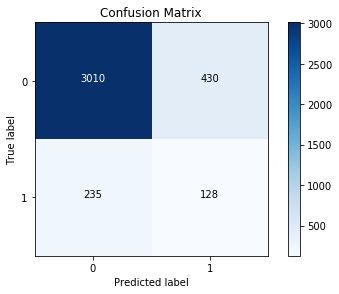

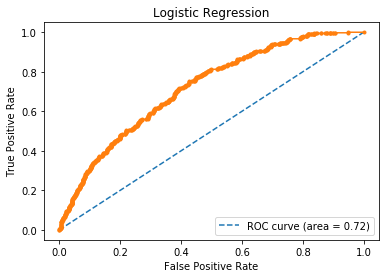

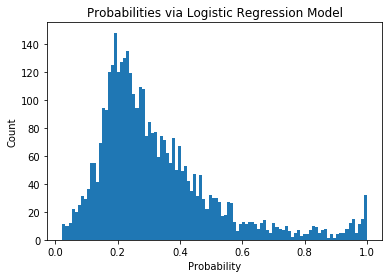

In [66]:
# Logistic Regression Model
import matplotlib
clf_LR = LogisticRegression(random_state=1)

ypred_LR = run_clf(clf_LR, 'Logistic Regression', X_train_nr, y_train_nr, csv_test.iloc[:,:-1], csv_test.iloc[:,-1])

Text(0.5,1,'Logistic Regression')

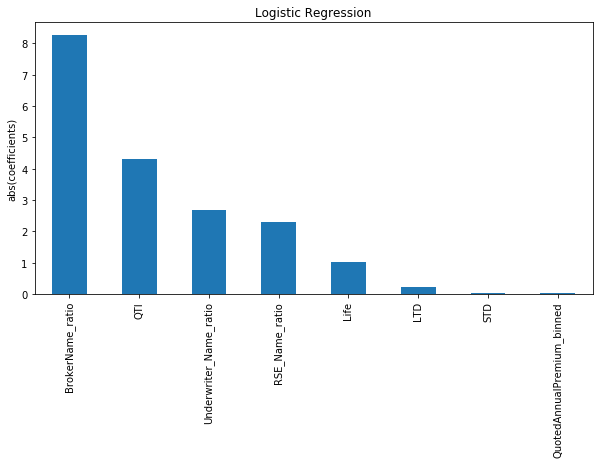

In [67]:
# Plot absolute value of coefficients from Logistic Regression model

plot_features(clf_LR.coef_[0], csv_train.iloc[:,:-1].columns)
plt.ylabel('abs(coefficients)')
plt.title('Logistic Regression')

Logistic Regression Test Accuracy: 0.4972
Logistic Regression Precision: 0.8264
Logistic Regression Recall: 0.1396
Logistic Regression F1: 0.4830


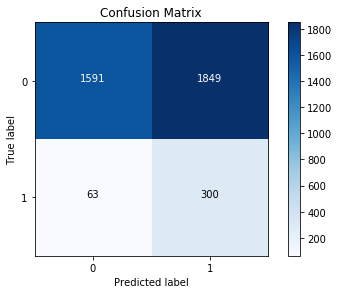

In [68]:
probs_LR = clf_LR.predict_proba(csv_test.iloc[:,:-1])
probs_LR = probs_LR[:,1]

threshold = 0.25

print_cm(csv_test.iloc[:,-1].values, probs_LR > threshold)
print("Logistic Regression Test Accuracy: %.4f" % accuracy_score(csv_test.iloc[:,-1].values, probs_LR > threshold))
precision_LR, recall_LR, f1_LR = metrics(csv_test.iloc[:,-1].values, probs_LR > threshold)
print("Logistic Regression Precision: %.4f" % precision_LR)
print("Logistic Regression Recall: %.4f" % recall_LR)
print("Logistic Regression F1: %.4f" % f1_LR)

In [69]:
LR_coef=pd.DataFrame(clf_LR.coef_, columns=csv_train.iloc[:,:-1].columns)
# print('Coefficients: \n', clf_LR.coef_)
# csv_train.iloc[:,:-1].columns
LR_coef

,RSE_Name_ratio,BrokerName_ratio,Underwriter_Name_ratio,Life,LTD,STD,QuotedAnnualPremium_binned,QTI
0,2.312808,8.25731,2.688725,-1.03704,-0.223795,-0.05043,-0.035333,-4.303979


### 3.2) Random Forests

In [70]:
Kevin_train=pd.read_csv('Kevin_X_train.csv', index_col = 0)

len(Kevin_train)
Kevin_train.info()
Kevin_train.sum()
# diff=Kevin_train.equals(X_train_nr)
# diff

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2146 entries, 0 to 2145
Data columns (total 8 columns):
RSE_Name_ratio                2146 non-null float64
Underwriter_Name_ratio        2146 non-null float64
BrokerName_ratio              2146 non-null float64
Life                          2146 non-null float64
LTD                           2146 non-null float64
STD                           2146 non-null float64
QuotedAnnualPremium_binned    2146 non-null float64
QTI                           2146 non-null float64
dtypes: float64(8)
memory usage: 150.9 KB


RSE_Name_ratio                 218.138998
Underwriter_Name_ratio         225.243328
BrokerName_ratio               453.842540
Life                          1930.000000
LTD                           1451.000000
STD                           1142.000000
QuotedAnnualPremium_binned    1009.250000
QTI                           1077.913850
dtype: float64

In [71]:
len(csv_test)
csv_test.sum()

RSE_Name_ratio                 359.517175
BrokerName_ratio               296.163203
Underwriter_Name_ratio         353.695933
Life                          3542.000000
LTD                           2781.000000
STD                           2180.000000
QuotedAnnualPremium_binned    1891.000000
QTI                           2001.187600
Sold                           363.000000
dtype: float64

Baseline Accuracy: 0.9045
Random Forests Training Accuracy: 0.7256
Random Forests Test Accuracy: 0.7560
Random Forests Precision: 0.5069
Random Forests Recall: 0.1972
Random Forests F1: 0.3521


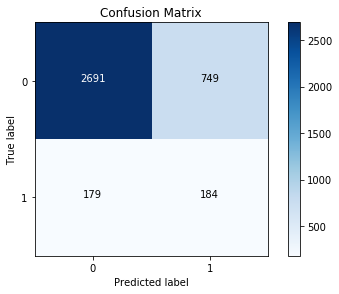

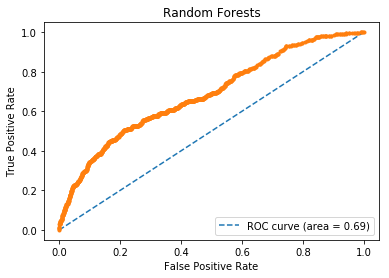

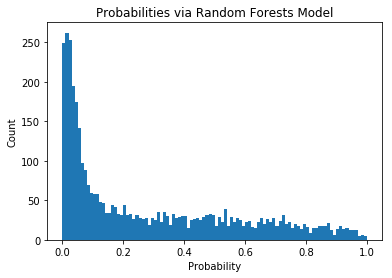

In [81]:
# Random forests model

clf_RF = RandomForestClassifier(random_state=1, n_estimators=1000)

ypred_RF = run_clf(clf_RF, 'Random Forests', X_train_nr, y_train_nr,
       csv_test.iloc[:,:-1], csv_test.iloc[:,-1])


In [79]:
XXtest=csv_test.iloc[:,:-1]
XXtest.QTI.sum()

2001.1876000000002

In [82]:
clf_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Text(0.5,1,'Random Forests')

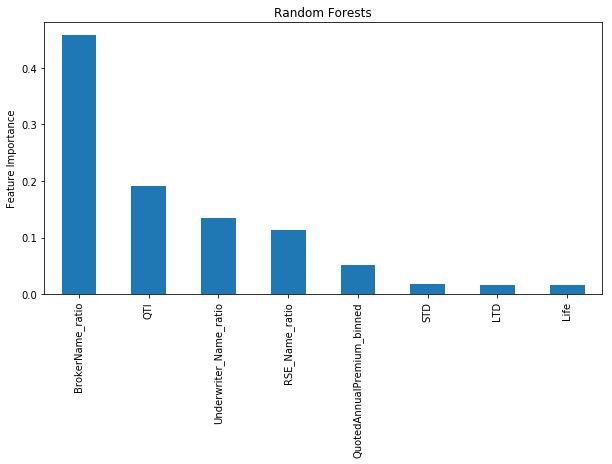

In [69]:
# Plot feature importances of Random Forests model

plot_features(clf_RF.feature_importances_, csv_train.iloc[:,:-1].columns)
plt.ylabel('Feature Importance')
plt.title('Random Forests')

Random Forest Test Accuracy: 0.7560
Random Forest Precision: 0.5069
Random Forest Recall: 0.1972
Random Forest F1: 0.3521


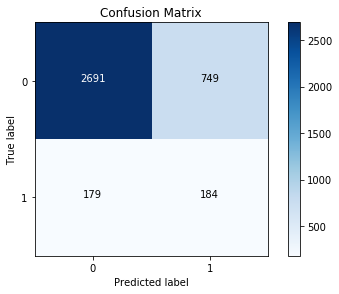

In [70]:
probs_RF = clf_RF.predict_proba(csv_test.iloc[:,:-1])
probs_RF = probs_RF[:,1]

threshold = 0.5

print_cm(csv_test.iloc[:,-1].values, probs_RF > threshold)
print("Random Forest Test Accuracy: %.4f" % accuracy_score(csv_test.iloc[:,-1].values, probs_RF > threshold))
precision_RF, recall_RF, f1_RF = metrics(csv_test.iloc[:,-1].values, probs_RF > threshold)
print("Random Forest Precision: %.4f" % precision_RF)
print("Random Forest Recall: %.4f" % recall_RF)
print("Random Forest F1: %.4f" % f1_RF)

### 3.3) Support Vector Machines

C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\katovc\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this

Baseline Accuracy: 0.9045
Support Vector Machines Training Accuracy: 0.6514
Support Vector Machines Test Accuracy: 0.8412
Support Vector Machines Precision: 0.2893
Support Vector Machines Recall: 0.2328
Support Vector Machines F1: 0.2610


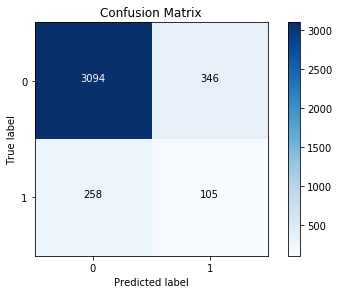

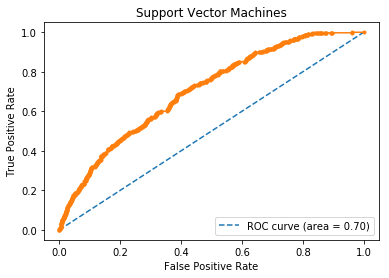

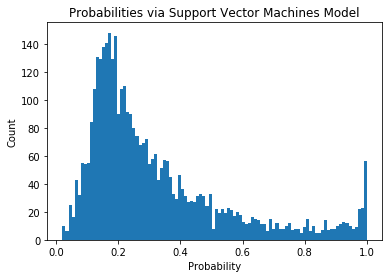

In [71]:
clf_SVC = SVC(probability = True)

ypred_SVC = run_clf(clf_SVC, 'Support Vector Machines', X_train_nr, y_train_nr,
       csv_test.iloc[:,:-1], csv_test.iloc[:,-1])

### 3.4) Linear Discriminant Analysis

Baseline Accuracy: 0.9045
Linear Discriminant Analysis Training Accuracy: 0.6356
Linear Discriminant Analysis Test Accuracy: 0.8357
Linear Discriminant Analysis Precision: 0.3636
Linear Discriminant Analysis Recall: 0.2510
Linear Discriminant Analysis F1: 0.3073


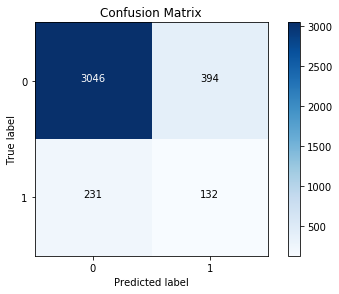

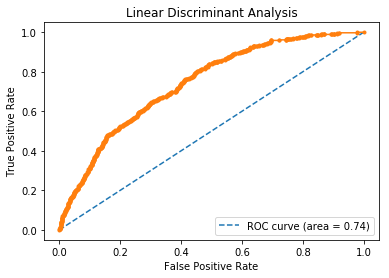

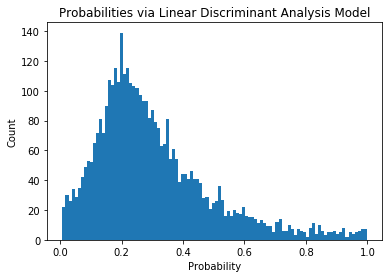

In [72]:
clf_LDA = LinearDiscriminantAnalysis()

ypred_LDA = run_clf(clf_LDA, 'Linear Discriminant Analysis', X_train_nr, y_train_nr,
       csv_test.iloc[:,:-1], csv_test.iloc[:,-1])

probs_LDA = clf_LDA.predict_proba(csv_test.iloc[:,:-1])
probs_LDA = probs_LDA[:,1]



Linear Discriminant Analysis Test Accuracy: 0.8357
Linear Discriminant Analysis Precision: 0.3636
Linear Discriminant Analysis Recall: 0.2510
Linear Discriminant Analysis F1: 0.3073


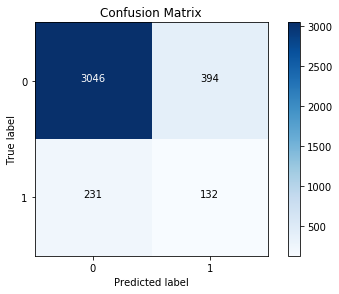

In [73]:
threshold = 0.5

print_cm(csv_test.iloc[:,-1].values, probs_LDA > threshold)
print("Linear Discriminant Analysis Test Accuracy: %.4f" % accuracy_score(csv_test.iloc[:,-1].values, probs_LDA > threshold))
precision_LDA, recall_LDA, f1_LDA = metrics(csv_test.iloc[:,-1].values, probs_LDA > threshold)
print("Linear Discriminant Analysis Precision: %.4f" % precision_LDA)
print("Linear Discriminant Analysis Recall: %.4f" % recall_LDA)
print("Linear Discriminant Analysis F1: %.4f" % f1_LDA)



### 3.5) Correlation Matrix

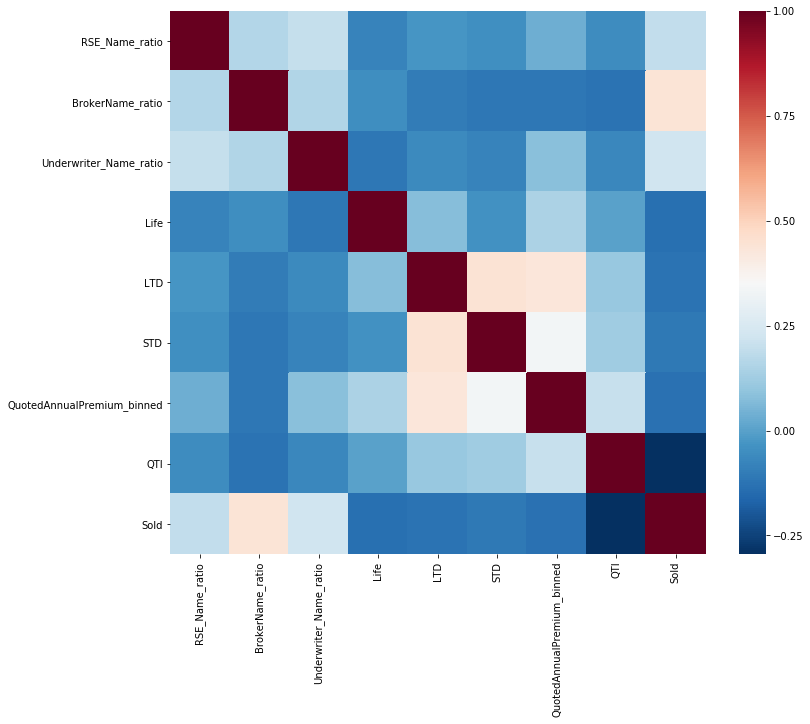

In [74]:
# Generate a correlation matrix. Note that the relationship between parameters
# will not be apparent if the data set remains imbalanced, so the cases were
# balanced to reflect a 1:1 ratio between Sold and Unsold cases:

train_sold = csv_train.loc[csv_train.Sold == 1] 
test_sold = csv_test.loc[csv_test.Sold == 1] 
train_unsold = csv_train.loc[csv_train.Sold == 0] 
test_unsold = csv_test.loc[csv_test.Sold == 0] 

df_unsold = pd.concat([train_unsold, test_unsold])

df_sold = pd.concat([train_sold, test_sold])

df_unsold_downsampled = resample(df_unsold, replace=True,    # sample without replacement
                                 n_samples=df_sold.shape[0],     # to match minority class
                                 random_state=123) # reproducible results
                                                 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_sold, df_unsold_downsampled])

# Display new class counts
df_downsampled.Sold.value_counts()

# Correlation plot
corr_downsampled = df_downsampled[csv_train.columns].corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_downsampled, xticklabels=csv_train.columns, yticklabels=csv_train.columns, ax=ax, cmap='RdBu_r')

## 3.6) Recreating Logistic Regression Model with 5 Most Important Features

In [75]:
clf_LR.coef_[0]

array([ 2.31280848,  8.25731002,  2.68872489, -1.03704031, -0.2237954 ,
       -0.05042993, -0.03533288, -4.30397872])

In [76]:
coef_Broker = clf_LR.coef_[0][3]
coef_QTI = clf_LR.coef_[0][28]
coef_Underwriter = clf_LR.coef_[0][2]
coef_RSE = clf_LR.coef_[0][0]
coef_RSS = clf_LR.coef_[0][1]

IndexError: index 28 is out of bounds for axis 0 with size 8

In [ ]:
coef = list([coef_Broker, coef_QTI, coef_Underwriter, coef_RSE, coef_RSS])

In [ ]:
reduced = csv_train[['BrokerName_ratio', 'QTI', 'Underwriter_Name_ratio', 'RSE_Name_ratio', 'RSS_Name_ratio']]

In [ ]:
reducedhist = np.matmul(reduced, coef)

In [ ]:
plt.figure(figsize=(10,8))

trial = pd.concat([csv_train, pd.Series(reducedhist, name='reducedhist')], axis=1)

plt.hist([trial[trial.Sold == 1].reducedhist,
         trial[trial.Sold == 0].reducedhist], stacked=True, bins=50)
plt.legend(["Sold", "Unsold"])

## 4) Feature Engineering: Closer look at 0.4 < QTI <= 1.0

In [ ]:
# Match QTI with its corresponding TP, TN, FN, FP label

results = pd.concat([pd.Series(csv_test.iloc[:,-1], name='ytest'), pd.Series(ypred_RF, name='ypred')], axis=1)
results['cm'] = 0

results.loc[np.logical_and(results.ytest == 1, results.ypred == 1), 'cm'] = 1
results.loc[np.logical_and(results.ytest == 0, results.ypred == 0), 'cm'] = 2
results.loc[np.logical_and(results.ytest == 1, results.ypred == 0), 'cm'] = 3
results.loc[np.logical_and(results.ytest == 0, results.ypred == 1), 'cm'] = 4

QTI_and_cm = pd.concat([pd.Series(csv_test.QTI, name='QTI'),
                        pd.Series(results.cm, name='cm')], axis=1)

In [ ]:
# Plot the distribution of QTI according to its confusion matrix label
# Plot shows that much of the misclassified cases occur near and less than QTI = 1.0

plt.figure(figsize=(10,8))
plt.hist([QTI_and_cm[QTI_and_cm.cm == 1].QTI * 2,
         QTI_and_cm[QTI_and_cm.cm == 2].QTI * 2,
         QTI_and_cm[QTI_and_cm.cm == 3].QTI * 2,
         QTI_and_cm[QTI_and_cm.cm == 4].QTI * 2], stacked=True, bins=50)
plt.legend(["TP", "TN", "FN", "FP"])
plt.xlabel('QTI')
plt.ylabel('Count')

In [ ]:
# Let's rerun the logistic Regression model, this time focusing only on the cases where 0.94 < QTI < 1.00

clf_LR = LogisticRegression()

ypred_LR = run_clf(clf_LR, 'Logistic Regression',
                   csv_train.loc[np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), 'RSE_Name_ratio':'QTI'],
                   csv_train.loc[np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), 'Sold'],
                   csv_test.loc[np.logical_and(csv_test.QTI > .94/2, 
                           csv_test.QTI <= 1/2), 'RSE_Name_ratio':'QTI'],
                   csv_test.loc[np.logical_and(csv_test.QTI > .94/2, 
                           csv_test.QTI <= 1/2), 'Sold'])

In [ ]:
# Plot coefficients of Logistic Regression model

plot_features(clf_LR.coef_[0], csv_train.iloc[:,:-1].columns)
plt.ylabel('abs(coefficients)')
plt.title('Logistic Regression')

In [ ]:
# Let's rerun the random forest model, this time focusing only on the cases where 0.94 < QTI < 1.00

clf_RF = RandomForestClassifier(random_state=1, n_estimators=1000)

ypred_RF = run_clf(clf_RF, 'Random Forests',
                   csv_train.loc[np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), 'RSE_Name_ratio':'QTI'],
                   csv_train.loc[np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), 'Sold'],
                   csv_test.loc[np.logical_and(csv_test.QTI > .94/2, 
                           csv_test.QTI <= 1/2), 'RSE_Name_ratio':'QTI'],
                   csv_test.loc[np.logical_and(csv_test.QTI > .94/2, 
                           csv_test.QTI <= 1/2), 'Sold'])

In [ ]:
# Plot feature importances of Random Forests model

plot_features(clf_RF.feature_importances_, csv_train.iloc[:,:-1].columns)
plt.ylabel('Feature Importance')
plt.title('Random Forests')

In [ ]:
# Plot the distribution of QTI according to its confusion matrix label

plt.figure(figsize=(10,8))
plt.hist([csv_train[csv_train.Sold == 1].BrokerName_ratio,
         csv_train[csv_train.Sold == 0].BrokerName_ratio], stacked=True, bins=50)
plt.legend(["Sold", "Unsold"])
plt.xlabel('BrokerName_ratio')
plt.ylabel('Count')

In [ ]:
# Plot the distribution of QTI according to its confusion matrix label

plt.figure(figsize=(10,8))
plt.hist([csv_test[csv_test.Sold == 1].BrokerName_ratio,
         csv_test[csv_test.Sold == 0].BrokerName_ratio], stacked=True, bins=50)
plt.legend(["Sold", "Unsold"])
plt.xlabel('BrokerName_ratio')
plt.ylabel('Count')

In [ ]:
# Zoom in for the range of 0.94 < QTI < 1.00

plt.figure(figsize=(10,8))
plt.hist([csv_train.loc[np.logical_and(np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), csv_train.Sold == 1), 'BrokerName_ratio'],
         csv_train.loc[np.logical_and(np.logical_and(csv_train.QTI > .94/2, 
                           csv_train.QTI <= 1/2), csv_train.Sold == 0), 'BrokerName_ratio']], stacked=True, bins=50)
plt.legend(["Sold", "Unsold"])
plt.xlabel('BrokerName_ratio')
plt.ylabel('Count')

In [ ]:
sum(csv_train[csv_train.BrokerName_ratio == 0].Sold == 0)

In [ ]:
sum(csv_train[csv_train.BrokerName_ratio == 0].Sold == 1)

In [ ]:
sum(csv_test[csv_test.BrokerName_ratio == 0].Sold == 0)

In [ ]:
sum(csv_test[csv_test.BrokerName_ratio == 0].Sold == 1)

In [ ]:
sum(csv_test[csv_test.BrokerName_ratio == 0].Sold == 1) / sum(csv_test[csv_test.BrokerName_ratio == 0].Sold == 0)

In [ ]:
# Deeper dive: Which Brokers have ratio = 0? How many cases? 

<h1> Predictions </h1>

In [ ]:
print(train[['RSE_Name','RSE_Name_ratio']][train['RSE_Name']=='Richard Bradford'].head(1))
print(train[['Underwriter_Name','Underwriter_Name_ratio']][train['Underwriter_Name']=='Matthew Jadovich'].head(1))
print(train[['BrokerName','BrokerName_ratio']][train['BrokerName']=='HUB International'].head(1))
print('Intercept: ',clf_LDA.intercept_)
print('Coefficients: ', clf_LDA.coef_)

In [ ]:
predict_case=np.array([0.07754, 0.099099, 0.068182, 1, 1, 1, 0.75, 0.46193089154665])
print('LR: ',clf_LR.predict_proba(predict_case.reshape(1, -1)))
print('RF: ',clf_RF.predict_proba(predict_case.reshape(1, -1)))
print('LDA: ',clf_LDA.predict_proba(predict_case.reshape(1, -1)))
print('SVM: ',clf_SVC.predict_proba(predict_case.reshape(1, -1)))